In [1]:
import numpy as np
import pandas as pd
import pickle
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from matplotlib import pyplot as plt
import os 
from functions import *
from enrichment import *
from matplotlib_venn import venn2, venn3
from dna_features_viewer import GraphicFeature, GraphicRecord
from scipy import stats
import networkx as nx

# Load dataset

In [2]:
gb_features = pd.read_csv('../data/genome/GCA_000203855.3_ASM20385v3_feature_table.txt',sep='\t')
gb_features = (gb_features[gb_features['# feature']=='gene']).reset_index().drop(['index'],axis=1)
gb_features = gb_features[['start','end','strand','feature_interval_length','symbol','locus_tag']]
gb_features = ( gb_features.dropna(subset=['locus_tag']) ).reset_index().drop(['index'],axis=1)
gb_features['symbol'] = gb_features['symbol'].fillna(gb_features['locus_tag'])

ref_features = pd.read_csv('../data/genome/GCF_000203855.3_ASM20385v3_feature_table.txt',sep='\t')
ref_features = ( ref_features[ref_features['# feature']=='gene']).reset_index().drop(['index'],axis=1)
ref_features = ref_features[['start','end','strand','feature_interval_length','symbol','attributes']]
ref_features = ( ref_features.dropna(subset=['attributes']) ).reset_index().drop(['index'],axis=1)
locus_tag=[]
for i in range(len(ref_features.index)):
    att = list(ref_features['attributes'])[i]
    if 'old_locus_tag=' in str( att ):
        locus_tag.append( str(att.split('=')[1]).strip()  )
    else:
        locus_tag.append('-')
ref_features['locus_tag']=locus_tag
ref_features = ref_features.drop(['attributes'], axis=1)
ref_features['symbol'] = ref_features['symbol'].fillna(ref_features['locus_tag'])

In [4]:
S = pd.read_csv('../data/IMdata/S.csv')
S = pd.read_csv('../data/IMdata/S.csv',index_col=0)
A = pd.read_csv('../data/IMdata/A.csv',index_col=0)
all_gene_ids = list(S.index)
log_rpkm_norm = pd.read_csv('../data/IMdata/log_rpkm_norm.csv', index_col=0)
log_rpkm = pd.read_csv('../data/IMdata/log_rpkm.csv',index_col=0)
IM_list = list(S.columns)

regulons = load_pickle('../data/IMdata/lpwcfs1_regulons.pkl')
regulators, gene_ids = [],[]
for k in regulons.keys():
    gene_ids += regulons[k]
    regulators += [ k for i in range(len(regulons[k])) ]
trn = pd.DataFrame(zip(regulators,gene_ids), columns=['regulator','gene_id'])

In [5]:
IMs = load_pickle('../data/IMdata/imodulon_genes.pkl')

In [6]:
def save_dict_fasta( seq_dict, out_path ):
    records = []
    for k in seq_dict:
        records.append( SeqRecord(Seq(seq_dict[k]), id = k, name="",description="") )
    SeqIO.write(records, out_path ,"fasta")

In [47]:
def get_sigcorr(reg_gene, im_genes, log_rpkm, G_name ):
    pearsonrs, pvalues = [],[]
    for gene in im_genes:
        coeff, pv = stats.pearsonr( log_rpkm.loc[reg_gene].values, log_rpkm.loc[gene].values )
        pearsonrs.append( coeff )
        pvalues.append( pv )
    temp_pd = pd.DataFrame(zip(im_genes,pearsonrs, pvalues), columns=['gene','coeff','pv'])
    temp_pd = ( temp_pd[temp_pd['pv']<0.05] ).reset_index()
    G=nx.Graph(name = G_name )
    G.add_nodes_from( [(G_name,{'color':'tab:orange'})]+[(v,{'color':'cyan'} ) for v in temp_pd['gene']])
    edge_list = []
    for i in range(len(temp_pd.index)):
        weight = list(temp_pd['coeff'])[i]
        if list(temp_pd['coeff'])[i] > 0:
            edge_list.append( (G_name,temp_pd['gene'][i],{'weight':abs(weight)*10,'edgecolor':'red'} ) )
        else:
            edge_list.append( (G_name,temp_pd['gene'][i],{'weight':abs(weight)*10,'edgecolor':'blue'} ) )
    G.add_edges_from(edge_list)
    return G  

# IM-1 case study

In [48]:
im1_promoters=get_im_promoters(IMs['1'], '../data/genome/sequence.fna', gb_features, ref_features)
# save_dict_fasta( im1_promoters, '../data/MEME_results/im1_promoters.fasta' )

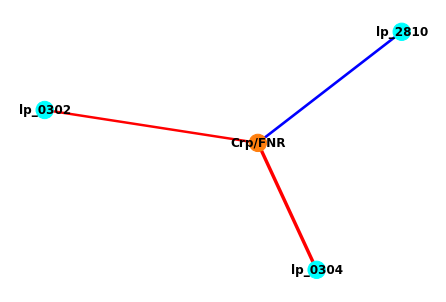

In [56]:
im1_corr = get_sigcorr('lp_1442', IMs['1'], log_rpkm, 'Crp/FNR' )
nodecolors = [ im1_corr.nodes.get(v)['color']for v in im1_corr.nodes]
edgecolors = [im1_corr[u][v]['edgecolor'] for u,v in im1_corr.edges]
weights = [im1_corr[u][v]['weight'] for u,v in im1_corr.edges]
nx.draw(im1_corr,with_labels = True,node_color=nodecolors,font_weight='bold',
            edge_color=edgecolors, width=weights)

# IM-16 case study

In [ ]:
im16_promoters=get_im_promoters(IMs['16'], '../data/genome/sequence.fna', gb_features, ref_features)
# save_dict_fasta( im16_promoters, '../data/MEME_results/im16_promoters.fasta' )

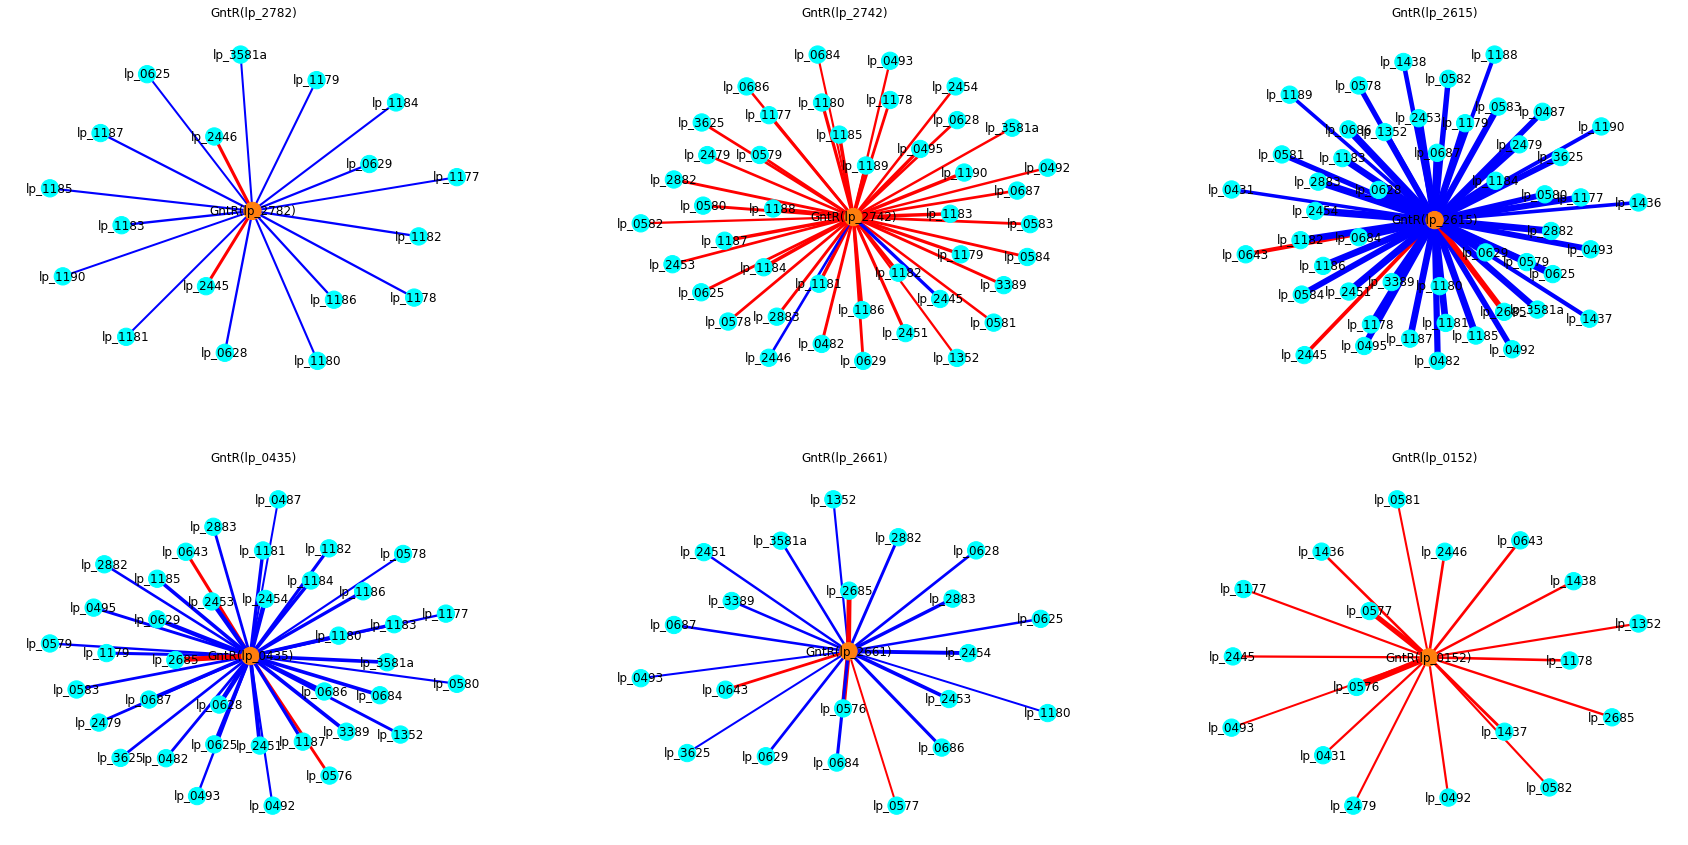

In [78]:
GntR_list = ['lp_2782', 'lp_2742', 'lp_2615', 'lp_0435','lp_2661','lp_0152']
G_im16 = []
for tf in GntR_list:
    G_im16.append( get_sigcorr(tf, IMs['16'], log_rpkm, 'GntR('+tf+')' ) )
    
fig,axs = plt.subplots(2,3,figsize=(30,15))
for i in range(6):
    x,y = int(i/3), int(i%3)
    G = G_im16[i]
    nodecolors = [ G.nodes.get(v)['color']for v in G.nodes]
    edgecolors = [ G[u][v]['edgecolor'] for u,v in G.edges]
    weights = [G[u][v]['weight'] for u,v in G.edges]
    nx.draw(G,with_labels = True,node_color=nodecolors,
            edge_color=edgecolors, width=weights, ax = axs[x][y])
    axs[x][y].set_title(G.name)